In [4]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib2 as urllib
import json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

In [7]:
# L1W3COZ1A3X7P0BJ
data_source = 'kaggle' # alphavantage or kaggle
data_source = 'kaggle' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'L1W3COZ1A3X7P0BJ'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:
    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')


Loaded data from the Kaggle repository


### Sort DataFrame by data

In [8]:
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


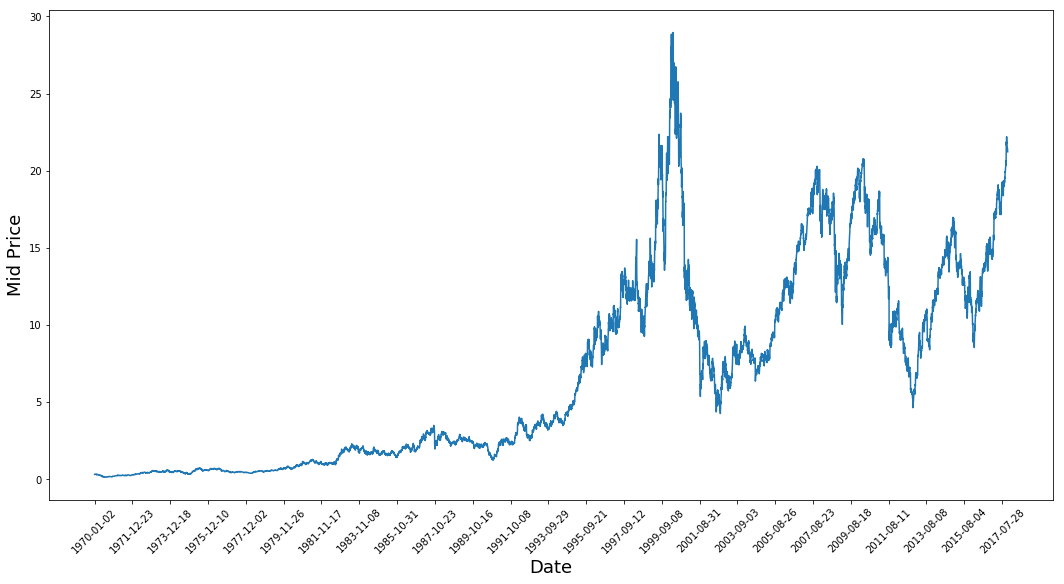

In [9]:
plt.figure(figsize=(18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

### Splitting Data into a Training set and a Test set

In [14]:
high_prices = df.loc[:,'High'].as_matrix()
# print(high_prices)
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0
print(mid_prices)

[ 0.30627   0.311975  0.311905 ... 21.355    21.275    21.225   ]


/home/kejsi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/kejsi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# The training data will be the first 11,000 data points of the time series and rest will be test data.
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

### Normalize Data

In [35]:
"""
Define a Scaler to normalize the data. 
I'll opt for MinMaxScaler of scikit. 
It will scale all data to be between 0 and 1
We also reshape the test data, to be in the form of:
   [data_size, num_features //dimesion]
"""
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1) # Transpose
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
test_data = test_data.reshape(-1,1)

In [37]:
"""
Since different time periods have different value ranges, 
we normalize the data by splitting the full series into windows.
Otherwise, the earlier data will be close to 0 and will not add
much value to the learning process. 
When choosing the window size make sure its not too small, because
when you perform windowed-normalization, it can introduce a break
at the very end of each window, as each window is normalized
independently
"""
smoothing_window_size = 2500
for i in range(0, 10000, smoothing_window_size):
    scaler.fit(train_data[i:i+smoothing_window_size,:])
    train_data[i:i+smoothing_window_size,:] = scaler.transform(train_data[i:i+smoothing_window_size,:])
# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


In [38]:
print(train_data)

[[0.01558203]
 [0.04646895]
 [0.07425491]
 ...
 [0.36416683]
 [0.36609824]
 [0.36710277]]


In [39]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [40]:
print(train_data)

[0.01558203 0.04646895 0.07425491 ... 0.36416683 0.36609824 0.36710277]


In [41]:
"""
    You can now smooth the data using the exponential moving average. 
    This helps you to get rid of the inherent raggedness of the data 
    in stock prices and produce a smoother curve.
"""
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

### One-Step Ahead Prediction via Averaging

In [42]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []
for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00432


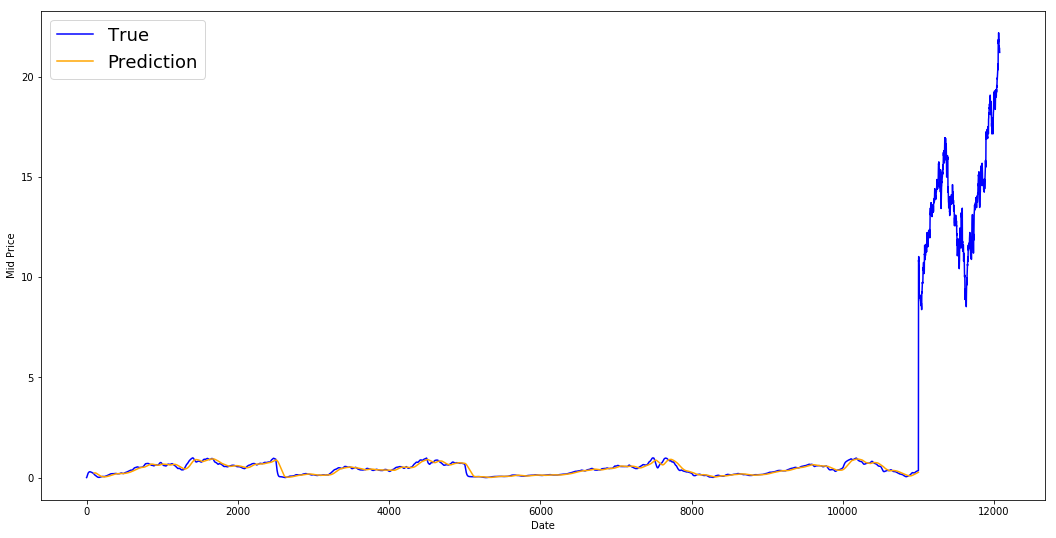

In [44]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### Transform Time Series data into Supervised Learning problem

In [46]:
from pandas import DataFrame
df = DataFrame()
df['t'] = [x for x in range(10)]
print(df)

   t
0  0
1  1
2  2
3  3
4  4
5  5
6  6
7  7
8  8
9  9


In [47]:
df['t-1'] = df['t'].shift(1)
print(df)

   t  t-1
0  0  NaN
1  1  0.0
2  2  1.0
3  3  2.0
4  4  3.0
5  5  4.0
6  6  5.0
7  7  6.0
8  8  7.0
9  9  8.0


In [49]:
from pandas import DataFrame
df = DataFrame()
df['t (X)'] = [x for x in range(10)]
df['t+1 (Y)'] = df['t (X)'].shift(-1)
print(df)


   t (X)  t+1 (Y)
0      0      1.0
1      1      2.0
2      2      3.0
3      3      4.0
4      4      5.0
5      5      6.0
6      6      7.0
7      7      8.0
8      8      9.0
9      9      NaN


In [50]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [51]:

values = [x for x in range(10)]
data = series_to_supervised(values, 3)
print(data)

   var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
3        0.0        1.0        2.0        3
4        1.0        2.0        3.0        4
5        2.0        3.0        4.0        5
6        3.0        4.0        5.0        6
7        4.0        5.0        6.0        7
8        5.0        6.0        7.0        8
9        6.0        7.0        8.0        9


In [ ]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


values = [x for x in range(10)]
data = series_to_supervised(values, 2, 2)
print(data)